# Solution to CHEN9007 Thermodynamics Assignment, 2017

## 1. Construct p-V diagram, plotting isotherms.

Construct a Pressure – Specific Volume plot containing isotherms for a fluid described by the van der Waals equation of state, showing clearly the two-phase liquid-vapour region. You are not required to show the solid phase boundary. In point form, detail your methodology such that the work could be repeated if necessary. Include a description of any solution methods (e.g. iterative approaches in excel or cubic solution in Matlab; do not give code or excel spreadsheet data).

The van der Waals equation is:

$$
p = \frac{RT}{v-b} - \frac{a}{v^2},
$$

or, in terms of the compressibility factor $Z\equiv pv/RT$,

$$
Z^3-(B+1)Z^2+AZ-AB=0
$$

where $A\equiv ap/R^2T^2$ and $B = bp/RT.$ Both $a$ and $b$ are gas-specific constants - each team has a different gas. The fugacity of a VdW fluid s given by:

$$
\log \frac{f}{p} = (Z-1) - \log(Z-B)-\frac{A}{Z}
$$


Methodology:

 - For those temperatures $\geq T_c$, just use the VdW equation above.
 - For those temperatures $\leq T_c$, use either the equal areas rule, or the condition of equal fugacity in the vapor and liquid phase. Either method will require iteration: we assume a vapor pressure (i.e. a pressure at which we think the liquid and gas will be at equilibrium for that temperature) and we check if the fugacities/areas are equal. We keep looking for pressures until we find one that works. In particular, we iteratively repalce $p$ with $p\times f_l/f_v$ until $f_l\approx f_v$.
 
The VdW equation can be written as:

$$
pv^3 - (pb+RT)v^2 + av - ab = 0.
$$

This is a cubic equation, the general solution to which is given in Wikipedia:

https://en.wikipedia.org/wiki/Cubic_function

I create a function which implements this general solution, in order to invert the cubic equation and find $v(T,p)$. Note that under some conditions there are 3 values of $v$ for each $(T,p)$ combination. While this is algebraically complicated, it saves us a lot of hastle searching for roots.

We also need a good initial guess for the vapor pressure when $T<T_c$, in order to start the iterative process described above. For this, I take the derivative of the VdW equation, and set $(\partial p/\partial v)|_T = 0$. Rearranging, we get the following cubic equation:

$$
\frac{RT}{2ab^2}v^3 - \frac{v^2}{b^2} + \frac{2v}{b} - 1 = 0
$$

I will put this into the same cubic solver to calculate the 2 turning points of the VdW equation. My first guess for the saturation pressure will then be the VdW equation's prediction for $p$ at the midpoint between the peak and the trough of the VdW equation. This cubic actually has 3 roots, but the smallest is at $v < b$, and is non-physical. We thus only take the 2 highest roots.

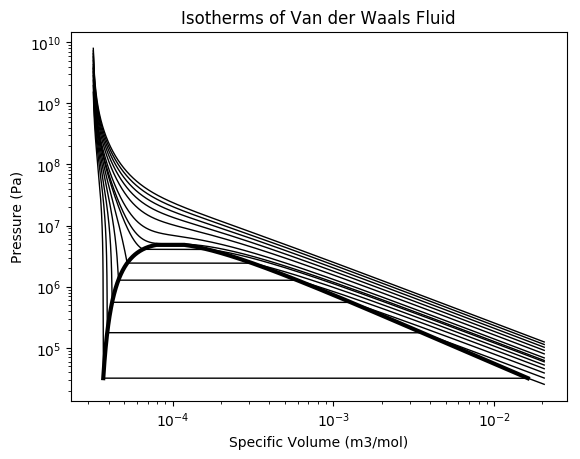

In [5]:
#-----Call packages-----#

using PyPlot                                                     #Call Plotting Package


#-----Define Parameters-----#

R = 8.314                                                        #Ideal gas constant, J/K.mol
a = 0.1381                                                       #a, VdW constant, m^6/mol^2
b = 3.184e-5                                                     #b, VdW constant, m3/mol
Tc = 154.6                                                       #Critical Temperature, K
pc = 5.046e6                                                     #Critical Pressure, Pa
Tvals = [linspace(0.41Tc,0.95Tc,6);Tc;linspace(1.1Tc,2Tc,6)]      #Values of Temperature for plotting, K


#-----Define Functions------#

p(v,T) = R*T/(v-b) - a/v^2                                       #Equation of State of VdW fluid, Pa
T(p,v) = (p+a/v^2)*(v-b)/R                                       #Rearranged Equation of State of VdW fluid, K
Z(p,v,T) = p*v/(R*T)                                             #Compressiblity Factor
f(p,Z,T) = Z-b*p/(R*T) > 0 ? p*exp((Z-1) - log(Z-b*p/(R*T)) - a*p/(R^2*T^2)/Z) : 0    #Fugacity of VdW Fluid, Pa; Be aware that errors will occur if this is evaluated where p(v,T) < 0, as this will give Z-B < 0 as well.


#-----Define Function for Solving Cubic Equation using formula from Wikipedia, and Apply to VdW Equation-----#

function rootscubic(a1,a2,a3,a4)                                                           
    Δ = 18*a1*a2*a3*a4 - 4*a2^3*a4 + a2^2*a3^2 - 4a1*a3^3 - 27a1^2*a4^2    #Discriminant of cubic.
    Δ0 = a2^2 - 3*a1*a3                                                    #Constant Δ0 from Wikipedia page
    Δ1 = 2*a2^3 - 9*a1*a2*a3 + 27*a1^2*a4                                  #Constant Δ1 from Wikipedia page
    if Δ < 0                                                               #In this case, there is only 1 real root
        numroots = 1                                                       #numroots is the number of roots.
        C = cbrt((Δ1 + sign(Δ1)*sqrt(-27*a1^2*Δ))/2)                       #Constant C from the Wikipedia page
        root = -1/(3*a1)*(a2+C+Δ0/C)                                       #The one root of this equation
        return [numroots,root]                                             #Return the number of roots and the root as a vector
    elseif Δ > 0                                                           #In this case there are 3 real roots
        numroots = 3                                                       #numroots is the number of roots.
        C = ((Δ1 + sign(Δ1)*sqrt(-27*a1^2*Δ + 0im))/2)^(1/3)               #Constant C from the Wikipedia page
        ξ = -1/2+sqrt(3)/2*im                                              #Constant ξ from the Wikipedia page
        root1 = real(-1/(3*a1)*(a2+C+Δ0/C))                                #And these are the three roots
        root2 = real(-1/(3*a1)*(a2+ξ*C+Δ0/(ξ*C)))
        root3 = real(-1/(3*a1)*(a2+ξ^2*C+Δ0/(ξ^2*C)))
        return [numroots,root1,root2,root3]                                #Return the number of roots and the 3 roots as a vector
    elseif Δ == 0                                                          #Handle the special case of multiple roots
        if Δ0 == 0                                                         #From Wikipedia, the formula with 1 triple root
            numroots = 1
            root = -x2/(3x1)
            return [numroots,root]
        else
            numroots = 2                                                   #From Wikipedia, the formula with a double root (root1) and another single root
            root1 = (9*x1*x4-x2*x3)/(2Δ0)
            root2 = (4*x1*x2*x3-9*x1^2*x4-x2^3)/(x1*Δ0)
            return [numroots,root1,root2]
        end
    end
end
v(T,p) = rootscubic(p,-b*p-R*T,a,-a*b)                                     #Using the root finding algorithm, we constuct a VdW equation rearranged for specific volume, that returns either one solution (T>Tc) or 3 solutions, only 2 of which are physical (T<Tc), m3/mol


#-----Create function which calculates the saturation pressure as a function of temperature using fugacity method-----#


function p_sat(Ttemp)
    if Ttemp <= 0.0
        return "Temperature is above negative"
    elseif Ttemp > Tc
        return "Temperature is above critical emperature"                                                                   #If the temperature is above the critical point, the Van der Waals equation can be applied directly.
    else
        vguess = mean(sort(rootscubic(R*Ttemp/(2a*b^2),-1/b^2,2/b,-1))[2:3])         #As described above, our first guess for the pressure will be at the point between the two stationary points of the VdW equation. Typically 3 stationary points are found when T < Tc, but one is at v < b, and so is non-physical and is ignored. m3/mol
        pguess = p(vguess,Ttemp)                                                     #Evaluate p at the first guess position, Pa
        fl = 0.0; fv = 1.0;                                                          #Initial dummy values for fugacity of liquid and gas, Pa
        while abs(fl-fv) > 1e-6                                                      #While liquid and gas phase fugacities difer by more than some small tolerance, keep iterating 
            fl = f(pguess,Z(pguess,v(Ttemp,pguess)[2],Ttemp),Ttemp)                  #Calculate liquid fugacity, Pa
            fv = f(pguess,Z(pguess,v(Ttemp,pguess)[4],Ttemp),Ttemp)                  #Calculate gas fugacity, Pa
            pguess = pguess*fl/fv                                                    #Update guess for saturation pressure - see part D of notes for why we use this updating procedure, Pa 
        end        
        return pguess                                                                #After convergence is achieved, return saturation pressure, Pa
    end
end


#-----Create function which calculates the *actual* vapor pressure-----#
#-----as a function of T and v (i.e. a function p_actual(v,T) that-----#
#-----accounts for the saturation region)------------------------------#


function p_actual(vtemp,Ttemp)
    if Ttemp>=Tc
        return p(vtemp,Ttemp)                                                        #If T > Tc, there is no need to account for the saturation region, and the VdW equation gives the actual pressure, pa
    else
        psatval = p_sat(Ttemp)                                                       #For T < Tc, the system may be in the saturation region. Use p_sat(T) to calculate the saturation pressure, Pa
        vliqsat = v(Ttemp,psatval)[2]                                                #Specific volume of saturated liquid at temperature T, m3/mol
        vgassat = v(Ttemp,psatval)[4]                                                #Specific volume of saturated gas at temperature T, m3/mol
        if vliqsat < vtemp < vgassat
            return psatval                                                           #If inside the saturation region, return saturation pressure, Pa
        else
            return  p(vtemp,Ttemp)                                                   #Otherwise, return pressure as predicted by VdW equation, Pa
        end
    end
end


#-----Make p-v plot-----#

#Plot Isotherms
vc = v(Tc,pc)[2]                                         #Critical volume, m3/mol
for i in 1:length(Tvals)
    Tloop = Tvals[i]
    vvals = logspace(log10(1.01b),log10(200vc),5000)                   #Values of which volume is plotted, m3/mol
    pvals = [p_actual(v,Tloop) for v in vvals]           #Calculate pressure values using p_actual(v,T), Pa
    loglog(vvals,pvals,"k",linewidth=1)                  #Plots Isotherms on loglog plot.
end

#Plot saturation curve.                                    
pvregionTvals = logspace(log10(Tvals[1]),log10(Tc*0.99),500)           #We will also plot the boundary of the saturation region
pvregionpvals = zeros(1000)
pvregionvvals = zeros(1000)
counter = 1
for Ttemp in pvregionTvals                               
    pvregionpvals[counter] = p_sat(Ttemp)                                  #Saturation pressure at each temperature value, Pa
    pvregionpvals[1001 - counter] = p_sat(Ttemp)
    pvregionvvals[counter] = v(Ttemp,pvregionpvals[counter])[2]            #Saturated liquid specific volume at each temperature, m3/mol
    pvregionvvals[1001 - counter] = v(Ttemp,pvregionpvals[counter])[4]     #Saturated gas specific volume at each temperature, m3/mol
    counter += 1
end
loglog(pvregionvvals,pvregionpvals,"-k",linewidth=3)

#Some minor titivation
title("Isotherms of Van der Waals Fluid")
xlabel("Specific Volume (m3/mol)")
ylabel("Pressure (Pa)")


## 2. Construct p-h diagram, plotting isotherms.

Construct a Pressure – Specific Enthalpy plot containing isotherms for your substance. Describe
your method and state clearly your reference temperature and pressure.

The enthalpy, $h(T,P)$, is given in terms of departure functions as:

$$
h(T,p)-h^{IG}(T^{ref},p^{ref}) = (h-h^{IG})_{T,p}+\int_{T^{ref}}^{T}c_p^*dT
$$

where $h^{IG}(T^{ref},p^{ref})$ is usually chosen as $0$. $(h-h^{IG})_{T,p}$ for an ideal gas is given by the equation below. Compute using the values of $Z$ found in Part 1 for each set of $(T,p)$ values:

$$
(h-h^{IG})_{T,p} = RT\left(Z-1-\frac{A}{Z}\right)
$$

The ideal gas constant pressure heat capacity, $c_p^*(T) = c_p(p \rightarrow 0,T)$ is given by:

$$
c_p^*(T) = c_1 + c_2T+c_3T^2+c_4T^3.
$$

Methodology:
 - The first thing we need to do is actually construct that function for $Z(T,p)$. We currently have $Z(p,v,T)$, but of course $v$ can be determined from $p$ and $T$. This in turn requires a tiny bit of work, as we must construct a $v_actual(T,p)$ function which, much like the $p_actual(v,T)$ function, accounts for the saturation region correctly.
 - Once we have $Z(T,p)$, it's easy to work out all of the terms as functions of $(T,p)$, and in particular to construct a function $h(T,p)$. We will set $T_{ref} = T_c$ (the value of $p_{ref}$ is irrelevant as, for ideal gases, $h$ is not a function of $p$.) 
 - With a $h(T,p)$ function, it is straightforward to hold $T$ constant, vary $p$, calculate $h$ values, and plot the isotherms on a $p-h$ diagram.

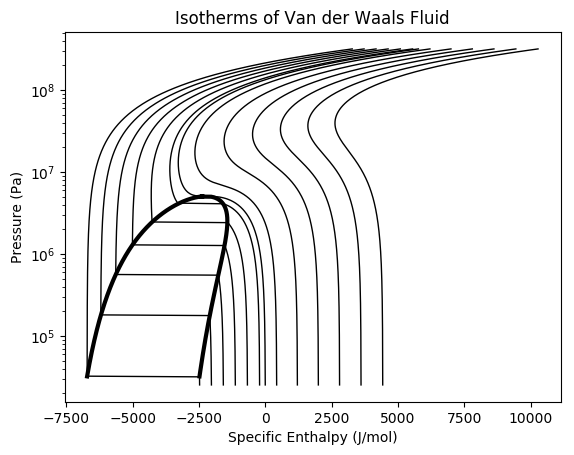

PyObject <matplotlib.text.Text object at 0x32f806ed0>

In [6]:
#-----Define parameters-----#

c1 = 25.460                           #J/mol.K
c2 = 1.519e-2                         #J/mol.K^2
c3 = -0.715e-5                        #J/mol.K^3
c4 = 1.311e-9                         #J/mol.K^4
Tref = Tc                             #Reference temperature, K
hIGRef = 0                            #Reference Ideal Gas Enthalpy, which we typically set to 0, J/mol


#-----Define a v_actual(T,p) function , which will properly account for the saturation region-----#

function v_actual(Tval,pval)                                #This is just the inverse of p_actual(v,T) when T is held constant
    if Tval >= (Tc-4e-1)                                    #If the temperature is above the saturation temperature, or at least very close to it, to avoid numerical problems
        return v(Tval,pval)[2]                              #Return the volume as predicted by the inversion of the VdW equation. m3/mol
    else                                                    #Else T < Tc, and so we must account for the saturation region,
        psatval = p_sat(Tval)                               #Saturation pressure at this temperature, Pa
        if pval >= psatval                                  #If we are in the liquid state,
            return v(Tval,pval)[2]                          #Return the liquid volume, m3/mol
        else                                                #Else if we're in the gas phase (note that the saturated region is an infinitely thin step change on a p-T plot)
            return v(Tval,pval)[end]                        #Return the gas volume (either the 2nd or 4the entry in v(T,p), but in either case the last entry of the vector), m3/mol
        end
    end
end

#-----Define Functions-----#

Z_actual(T,p) = Z(p,v_actual(T,p),T)                                           #Function for compressibility factor, Z, in terms of just T and p. This will undergo a step change at the phase transition.              
htakehIG(T,p) = R*T*(Z_actual(T,p)-1-a*p/(R^2*T^2)/Z_actual(T,p))              #Departure function for enthalpy in terms of T and p. This will also undergo a step change at the phase transition.
cpIG(T) = c1+c2*T+c3*T^2+c4*T^3                                                #Ideal gas heat capacity, J/mol
cpIGIntegral(T) = c1*(T-Tref) + c2/2*(T^2-Tref^2) + c3/3*(T^3-Tref^3) + c4/4*(T^4-Tref^4)              #Integral of ideal gas heat capacity between Tref and T, J/mol.
h(T,p) = hIGRef + htakehIG(T,p)+cpIGIntegral(T)                                #Enthalpy of the fluid, J/mol


#-----Make Plots-----#

#Plot Isotherms
for Tloop in Tvals
    pvals = logspace(log10(0.005pc),8.5,500)
    hvals = [h(Tloop,p) for p in pvals]
    semilogy(hvals,pvals, "k", linewidth=1)
end

#Plot saturation curve
pvregionTvals = linspace(Tvals[1],Tc*0.999,5000)           #We will also plot the boundary of the saturation region
pvregionpvals = zeros(10000)
pvregionhvals = zeros(10000)
counter = 1
for Ttemp in pvregionTvals                               
    pvregionpvals[counter] = p_sat(Ttemp)                                      #Saturation pressure at each temperature value, Pa
    pvregionpvals[10001 - counter] = p_sat(Ttemp)
    pvregionhvals[counter] = h(Ttemp,pvregionpvals[counter]*1.00001)          #Saturated liquid enthalpy at each temperature, J/mol
    pvregionhvals[10001 - counter] = h(Ttemp,pvregionpvals[counter]*0.9999)     #Saturated gas enthalpy at each temperature, J/mol
    counter += 1
end
semilogy(pvregionhvals,pvregionpvals,"-k",linewidth=3)

#Some minor titivation
title("Isotherms of Van der Waals Fluid")
xlabel("Specific Enthalpy (J/mol)")
ylabel("Pressure (Pa)")


# 3. Construct T-s diagram, showing isobars

Construct a Temperature – Specific Entropy plot containing isobars for your chosen van der Waals gas. Describe your method and state clearly your reference temperature and pressure.

The entropy, $s(T,P)$, is given in terms of departure functions as:

$$
s(T,p) - s^{IG}(T^{ref},p^{ref}) = (s-s^{IG})|_{T,p} + \int_{T^{ref}}^{T}\frac{c_p^*(T)}{T} dT - R\log \frac{p}{p^{ref}}
$$

$s^{IG}(T^{ref},p^{ref})$ is usually chosen as $0$. $(s-s^{IG})|_{T,p}$ for the Van der Waals gas is given by

$$
(s-s^{IG})|_{T,p} = R \log (Z-B)
$$

Methodology
 - We first construct a function for $\int_{T^{ref}}^{T}\frac{c_p^*(T)}{T} dT$ and for $(s-s^{IG})|_{T,p}$ as functions of $T$ and $p$. 
 - We next construct $s(T,p)$. To do this we will need to set a reference pressure. It makes physical sense to set this at a condition at which the gas is ideal (though strictly speaking this isn't necessary) and all gases used in this assignment (with the possible exception of helium) will be ideal at 1 bar ($10^5$ Pa) and a temperature of $T_c$, so this is the reference pressure I will use.
 - Once again, plots are relatively straightforward to construct.

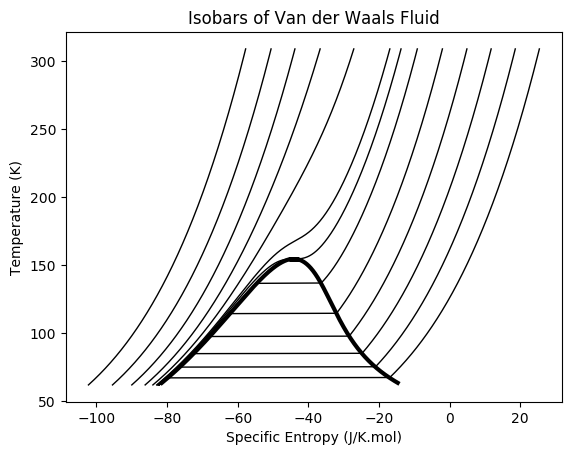

PyObject <matplotlib.text.Text object at 0x32fb35850>

In [7]:
#-----Define Parameters-----#
pref = 1e5                         #Reference Pressure, Pa
sIGref = 0                         #Reference ideal gas entropy, typically set to 0, J/K.mol

#-----Define Functions-----#
cponTintegral(T) = c1*log(T/Tref) + c2*(T-Tref) + c3/2*(T^2-Tref^2) + c4/3*(T^3-Tref^3)            #Integral of cpstar/T from Tref to T, J/K.mol
s(T,p) = sIGref + R*log(Z_actual(T,p)-b*p/(R*T)) + cponTintegral(T) - R*log(p/pref)                #Entropy of VdW fluid as a function of T and p, J/K.mol

#-----Make Plots-----#

#Isobars
pvals = [logspace(log10(0.01pc), log10(pc*0.6),6);pc;logspace(log10(pc*1.4),9,6)]
Tvalsplot = linspace(0.4Tc,2Tc,1000)
for ptemp in pvals
    svalsplot = [s(Ttemp,ptemp) for Ttemp in Tvalsplot]
    plot(svalsplot,Tvalsplot,"k",linewidth=1)
end

#Plot saturation curve
satregionTvals = linspace(Tvals[1],Tc*0.999,5000)                             #We will also plot the boundary of the saturation region
satregionTvalsplot = zeros(10000)
satregionsvalsplot = zeros(10000)
counter = 1
for Ttemp in satregionTvals                               
    ptemp = p_sat(Ttemp)                                                     #Saturation pressure at each temperature value, Pa
    satregionTvalsplot[counter] = Ttemp                                      #Temperature along saturated liquid side of curve, K
    satregionTvalsplot[10001 - counter] = Ttemp                              #Temperature along saturated gas side of curve, K
    satregionsvalsplot[counter] = s(Ttemp*0.9999,ptemp)                        #Entropy along saturated liquid side of curve, J/K.mol
    satregionsvalsplot[10001 - counter] = s(Ttemp*1.0001,ptemp)                #Entropy along saturated gas side of curve, J/K.mol
    counter += 1
end
plot(satregionsvalsplot,satregionTvalsplot,"-k",linewidth=3)


#Some minor titivation`
title("Isobars of Van der Waals Fluid")
xlabel("Specific Entropy (J/K.mol)")
ylabel("Temperature (K)")

## 4. Cycle Optimisation.

Combine your van der Waals gas and thermodynamic cycle to determine, within certain constraints, the minimum flowrate to provide a certain output.

Each team has been assigned one of the ideal thermodynamic cycles from Table 3. Each cycle consists of four processes that can be approximated by compression, heat addition, expansion and heat rejection.

Determine the minimum mass flowrate for your cycle under the following constraints:
- The cycle must have a maximum power generation of 1 MW. This is the work generated by expansion minus the work required for compression.
- The material must be a vapour throughout the cycle (even if your particular cycle is historically used for modelling liquid or liquid/vapour systems).
- The maximum temperature (TH) is 2 Tc.
- The pressure must be between 0.01 Pc < P < Pc.
Perform appropriate calculations for mass, energy and entropy balances over each unit operation.

Remember, you have a van der Waals gas, not an ideal gas.

There are several degrees of freedom in this process to optimise the throughput. Include a description of your optimisation process and justification of any assumptions.

Reproduce your P-v, P-h and T-s diagrams with the thermodynamic cycle, saturated region and constrains clearly shown.

Methodology.
- Each cycle is completely determinted by the choice of 2 $(p,v)$ points at opposite corners of the cycle. We can thus define our cycle by the 4 values $p_1,v_1,p_2,v_2$. Given these points, the first step will be to follow along the various isobars, isotherms, adiabats, etc., to find the other 2 corners of the cycle.
- Once all 4 corners of the cycle are known, the next step is to calculate the heat and work done along each path. This integration will be different for the different kinds of paths. Below, we analyse several types of paths. We can combine these steps to create a function which takes, as input, $(p_1,v_1,p_2,v_2)$ and gives as output the overall work and heat outputs of the cycle.
- Finally, once we have this function, we will optimise to maximise either cycle efficiency or work output per cycle (two different interpretations of the question.) For a Carnot Cycle, we make the following observations:
    1. The largest area will be obtained when $Tmax = 2Tc$.
    2. The largest area will be obtained when $p_1$ (at the start of adiabatic compression) is saturated.
    3. The largest area will be obtained when $p_4 = 0.01pc$. 
- Thus, for the Carnot cycle, we just need to vary point 4 and calculate the work output for the cycle.

#### Calculation of work and heat for various paths.

For various paths, we can relate the heat and work along the path to the values of the state functions we have already constructed ($h(T,p)$ and $s(T,p)$) at the begigning end points of the path.

Adiabatic:
- $q = 0$
- $\Delta s = 0$
- $w = \Delta u = \Delta h(T,p) - \Delta (pv) $

Isothermal:
- $q = T\Delta s(T,p)$
- $w = \Delta u - q = \Delta h(T,p) - \Delta (pv) - T\Delta s(T,p)$

Isobaric:
- $w = -p\Delta v$
- $q = \Delta u - w = \Delta h(T,p) - \Delta (pv) + p \Delta v = \Delta h(T,p) - p\Delta v + p \Delta v =\Delta h(T,p) $

Isochoric:
- $w = 0$
- $q = \Delta u = \Delta h(T,p) - \Delta (pv)$

In [ ]:
#-----Call Libraries-----#

using Roots                                        #Call Root-finding library
using Optim                                        #Call Optimisation Library

#-----Carnot Cycle Corner Finding Function-----#

#This function will take 4 values, $p1,T1,P3,T3$, and will spit out 
#The other 4 corner values of the Carnot Cycle. P1,T1 refer to the 
#State just before the compression step.

function CarnotCorner(T1,p1,T3,p3)
    T2 = T3                               #Temperature is constant along isotherm, K
    T4 = T1                               #Temperature is constant along isotherm, K
    Δs_Carnotline1(p2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Carnotline2(p4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    p2 = fzero(Δs_Carnotline1,1e-40pc, 1e40pc)
    p4 = fzero(Δs_Carnotline2,1e-40pc, 1e40pc)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]
end

#-----Calculate Heat and Work Output along Diferent Curves-----#
#-----Here (T0,p0) is the starting point of the curve, and-----#
#-----(Tf,pf) the final point of the curve---------------------#

function adiabatoutput(T0,p0,Tf,pf)
    q = 0
    w = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0))
    return [q,w]
end

function isothermout(T0,p0,Tf,pf)
    q = T0*(s(Tf,pf)-s(T0,p0))
    w = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0)) - q
    return [q,w]
end

#-----Function for Work Output From Carnot Cycle-----#

function w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)
    (p1,T1,p2,T2,p3,T3,p4,T4) = CarnotCorner(T1,p1,T3,p3)
    temp = adiabatoutput(T1,p1,T2,p2) + isothermout(T2,p2,T3,p3) + adiabatoutput(T3,p3,T4,p4) + isothermout(T4,p4,T1,p1)
    qtot = temp[1]
    wtot = temp[2]
    return [qtot,wtot]
end


#-----Optimise Cycle to Maximise -w subject to constraints-----#
function w_optimisation(T4)
    T1 = T4
    p1 = p_sat(T4)
    T3 = 2Tc
    p3 = x[4]
    p4 = 0.01pc
    tempvals = CarnotCorner(T1,p1,T3,p3)
    p2 = tempvals[3]
    T2 = tempvals[4]
    p4 = tempvals[7]
    T4 = tempvals[8]
    
    w = w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)[2]
    
    if max(T1,T2,T3,T4) > 2Tc
        w = w + 10
    end
    if max(p1,p2,p3,p4) > pc || min(p1,p2,p3,p4) < 0.01pc
        w = w + 10
    end
    if T1 < Tc
        if p1 >= p_sat(T1) 
            w = w + 10
        end
    end
    return w
end

#Initial Guess
x0 = [1.1Tc,0.2pc,1.9Tc,0.5pc]
result = optimize(w_optimisation, x0, BFGS())


Combine your van der Waals gas and thermodynamic cycle to determine, within certain constraints, the minimum flowrate to provide a certain output.

Each team has been assigned one of the ideal thermodynamic cycles from Table 3. Each cycle consists of four processes that can be approximated by compression, heat addition, expansion and heat rejection.

Determine the minimum mass flowrate for your cycle under the following constraints:
- The cycle must have a maximum power generation of 1 MW. This is the work generated by expansion minus the work required for compression.
- The material must be a vapour throughout the cycle (even if your particular cycle is historically used for modelling liquid or liquid/vapour systems).
- The maximum temperature (TH) is 2 Tc.
- The pressure must be between 0.01 Pc < P < Pc.
Perform appropriate calculations for mass, energy and entropy balances over each unit operation.

Remember, you have a van der Waals gas, not an ideal gas.

There are several degrees of freedom in this process to optimise the throughput. Include a description of your optimisation process and justification of any assumptions.

Reproduce your P-v, P-h and T-s diagrams with the thermodynamic cycle, saturated region and constrains clearly shown.

Methodology.
- Each cycle is completely determinted by the choice of 2 $(p,v)$ points at opposite corners of the cycle. We can thus define our cycle by the 4 values $p_1,v_1,p_2,v_2$. Given these points, the first step will be to follow along the various isobars, isotherms, adiabats, etc., to find the other 2 corners of the cycle.
- Once all 4 corners of the cycle are known, the next step is to calculate the heat and work done along each path. This integration will be different for the different kinds of paths. Below, we analyse several types of paths. We can combine these steps to create a function which takes, as input, $(p_1,v_1,p_2,v_2)$ and gives as output the overall work and heat outputs of the cycle.
- Finally, once we have this function, we will optimise to maximise either cycle efficiency or work output per cycle (two different interpretations of the question.)

#### Calculation of work and heat for various paths.

For various paths, we can relate the heat and work along the path to the values of the state functions we have already constructed ($h(T,p)$ and $s(T,p)$) at the begigning end points of the path.

Adiabatic:
- $q = 0$
- $\Delta s = 0$
- $w = \Delta u = \Delta h(T,p) - \Delta (pv) $

Isothermal:
- $q = T\Delta s(T,p)$
- $w = \Delta u - q = \Delta h(T,p) - \Delta (pv) - T\Delta s(T,p)$

Isobaric:
- $w = -p\Delta v$
- $q = \Delta u - w = \Delta h(T,p) - \Delta (pv) + p \Delta v = \Delta h(T,p) - p\Delta v + p \Delta v =\Delta h(T,p) $

Isochoric:
- $w = 0$
- $q = \Delta u = \Delta h(T,p) - \Delta (pv)$

In [4]:
#-----Call Libraries-----#

using Roots                                        #Call Root-finding library
using Optim                                        #Call Optimisation Library

#-----Carnot Cycle Corner Finding Function-----#

#This function will take 4 values, $p1,T1,P3,T3$, and will spit out 
#The other 4 corner values of the Carnot Cycle. P1,T1 refer to the 
#State just before the compression step.

function CarnotCorner(T1,p1,T3,p3)
    T2 = T3                               #Temperature is constant along isotherm, K
    T4 = T1                               #Temperature is constant along isotherm, K
    Δs_Carnotline1(p2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Carnotline2(p4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    p2 = fzero(Δs_Carnotline1,1e-40pc, 1e40pc)
    p4 = fzero(Δs_Carnotline2,1e-40pc, 1e40pc)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]
end


#-----Brayton Cycle Corner Funding Function-----#

#This function will take 4 values, $p1,T1,P3,T3$, and will spit out 
#The other 4 corner values of the Brayton Cycle. P1,T1 refer to the 
#State just before the compression step.

function BraytonCorners(T1,p1,T3,p3)
    p2 = p3                               #Pressure is constant along isobar, Pa
    p4 = p1                               #Pressure is constant along isobar, Pa
    Δs_Braytonline1(T2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Braytonline2(T4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    T2 = fzero(Δs_Braytonline1,T1)
    T4 = fzero(Δs_Braytonline2,T3)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]
end


#-----Calculate Heat and Work Output along Diferent Curves-----#
#-----Here (T0,p0) is the starting point of the curve, and-----#
#-----(Tf,pf) the final point of the curve---------------------#

function adiabatoutput(T0,p0,Tf,pf)
    q = 0
    w = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0))
    return [q,w]
end

function isothermout(T0,p0,Tf,pf)
    q = T0*(s(Tf,pf)-s(T0,p0))
    w = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0)) - q
    return [q,w]
end

function isobarout(T0,p0,Tf,pf)
    q = -p0*(v_actual(Tf,pf)-v_actual(T0,p0))
    w = h(Tf,pf) - h(T0,p0)
    return [q,w]
end

function isochoreout(T0,p0,Tf,pf)
    w = 0
    q = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0))
    return [q,w]
end


#-----Function for Work Output From Carnot Cycle-----#

function w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)
    (p1,T1,p2,T2,p3,T3,p4,T4) = CarnotCorner(T1,p1,T3,p3)
    temp = adiabatoutput(T1,p1,T2,p2) + isothermout(T2,p2,T3,p3) + adiabatoutput(T3,p3,T4,p4) + isothermout(T4,p4,T1,p1)
    qtot = temp[1]
    wtot = temp[2]
    return [qtot,wtot]
end

#-----Function for Work Output From Brayton Cycle-----#

function w_and_q_of_Brayton_Cycle(T1,p1,T3,p3)
    (p1,T1,p2,T2,p3,T3,p4,T4) = BraytonCorners(T1,p1,T3,p3)
    temp = adiabatoutput(T1,p1,T2,p2) + isobarout(T2,p2,T3,p3) + adiabatoutput(T3,p3,T4,p4) + isobarout(T4,p4,T1,p1)
    qtot = temp[1]
    wtot = temp[2]
    return [qtot,wtot]
end

#-----Optimise Cycle to Maximise -w subject to constraints-----#
function w_optimisation(x)
    T1 = x[1]
    p1 = x[2]
    T3 = x[3]
    p3 = x[4]
    tempvals = CarnotCorner(T1,p1,T3,p3)
    p2 = tempvals[3]
    T2 = tempvals[4]
    p4 = tempvals[7]
    T4 = tempvals[8]
    
    w = w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)[2]
    
    if max(T1,T2,T3,T4) > 2Tc
        w = w + 10
    end
    if max(p1,p2,p3,p4) > pc || min(p1,p2,p3,p4) < 0.01pc
        w = w + 10
    end
    if T1 < Tc
        if p1 >= p_sat(T1) 
            w = w + 10
        end
    end
    return w
end

#Initial Guess
x0 = [1.1Tc,0.2pc,1.9Tc,0.5pc]
result = optimize(w_optimisation, x0, BFGS())


LoadError: DomainError:

In [17]:
s(Tc,-.01pc)

5.721621194155719

In [13]:
p_sat(Tc-Tc-1)

LoadError: BoundsError: attempt to access 2-element Array{Float64,1} at index [2:3]

In [5]:
temp = result.minimizer

LoadError: UndefVarError: result not defined

In [6]:
p_sat(T)

LoadError: MethodError: no method matching isless(::Float64, ::#T)[0m
Closest candidates are:
  isless(::Float64, [1m[31m::Float64[0m) at float.jl:283
  isless([1m[31m::PyCall.PyObject[0m, ::Any) at /Users/thomasmoore/.julia/v0.5/PyCall/src/pyoperators.jl:71
  isless(::AbstractFloat, [1m[31m::AbstractFloat[0m) at operators.jl:40
  ...[0m

In [7]:
2.523e6/pc

0.5

In [8]:
CarnotCorner(150.586,504600,301.271,2.523e6)

8-element Array{Float64,1}:
 504600.0      
    150.586    
      5.04592e6
    301.271    
      2.523e6  
    301.271    
      2.43933e5
    150.586    

In [9]:
w_optimisation([150.586,5.04600e5,301.271,2.523e6])
CarnotCorner(150.586,5.04600e5,301.271,2.523e6)

8-element Array{Float64,1}:
 504600.0      
    150.586    
      5.04592e6
    301.271    
      2.523e6  
    301.271    
      2.43933e5
    150.586    

In [10]:
x = [1.1Tc,0.1pc,1.8Tc,0.5pc]
T1 = x[1]
p1 = x[2]
T3 = x[3]
p3 = x[4]
tempvals = CarnotCorner(T1,p1,T3,p3)
p2 = tempvals[3]
T2 = tempvals[4]
p4 = tempvals[7]
T4 = tempvals[8]

w_optimisation(x0)

-991.9119025589093

In [11]:
min(p1,p2,p3,p4) >pc

false

In [12]:
T1 < Tc

false

In [13]:
CarnotCorners(1,3)

LoadError: UndefVarError: CarnotCorners not defined

In [14]:
function w_optimisation(x)
    T1 = x[1]
    p1 = x[2]
    T3 = x[3]
    p3 = x[4]
    tempvals = CarnotCorners(T1,p1,T3,p3)
    p2 = tempvals[3]
    T2 = tempvals[4]
    p4 = tempvals[7]
    T4 = tempvals[8]
    
    w = w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)[2]
    
    if max(T1,T2,T3,T4) > 2Tc
        w = w + 1e49
    end
    if max(p1,p2,p3,p4) > pc || min(p1,p2,p3,p4) < 0.01pc
        w = w + 1e49
    end
    if p1 >= p_sat(T1) || p2 >= p_sat(T2) || p3 >= p_sat(T3) || p4 >= p_sat(T4)  
        w = w + 1e49
    end
    
    return w
end

w_optimisation (generic function with 1 method)

In [15]:
x =  [Tc,0.2pc,1.3Tc,0.5pc]
T1 = x[1]
p1 = x[2]
T3 = x[3]
p3 = x[4]
tempvals = CarnotCorners(T1,p1,T3,p3)
p2 = tempvals[3]
T2 = tempvals[4]
p4 = tempvals[7]
T4 = tempvals[8]
w = w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)[2]

if max(T1,T2,T3,T4) > 2Tc
    w = w + 1e49
end
if max(p1,p2,p3,p4) > pc || min(p1,p2,p3,p4) < 0.01pc
    w = w + 1e49
end
if T
    if p1 > p_sat(T1) || p2 > p_sat(T2) || p3 > p_sat(T3) || p4 > p_sat(T4) 
        w = w + 1e49
    end


LoadError: UndefVarError: CarnotCorners not defined

In [16]:
using Optim
rosenbrock(x) =  (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
result = optimize(rosenbrock, zeros(2), BFGS()).minimum

5.471432684244042e-17

In [17]:
max(1.0,p_sat(300))

LoadError: MethodError: no method matching isless(::String, ::Float64)[0m
Closest candidates are:
  isless([1m[31m::Float64[0m, ::Float64) at float.jl:283
  isless([1m[31m::PyCall.PyObject[0m, ::Any) at /Users/thomasmoore/.julia/v0.5/PyCall/src/pyoperators.jl:71
  isless([1m[31m::AbstractFloat[0m, ::AbstractFloat) at operators.jl:40
  ...[0m

In [18]:
Pkg.add("BlackBoxOptim")

INFO: Nothing to be done
INFO: METADATA is out-of-date — you may not have the latest version of BlackBoxOptim
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [19]:
using BlackBoxOptim

In [20]:
using BlackBoxOptim

function rosenbrock2d(x)
  return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end

rosenbrock2d (generic function with 1 method)

In [21]:
res = bboptimize(rosenbrock2d; SearchRange = (-5.0, 5.0), NumDimensions = 2)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.14466094970703125 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 69134.06845630505
Function evals per second = 70157.15036126786
Improvements/step = 0.2085
Total function evaluations = 10149


Best candidate found: [1.0,1.0]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (10000) reached",10001,1.507548745797847e9,0.14466094970703125,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,(-5.0,5.0)),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:RngSeed,764031),Pair{Symbol,Any}(:NumDimensions,2)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],10149,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(1.7497349029777283e-25,[1.0,1.0]),BlackBoxOptim.Pop

In [22]:
bboptimize(rosenbrock2d; SearchRange = [(-5.0, 5.0), (-2.0, 2.0)])

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.025919198989868164 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 385852.9734622354
Function evals per second = 390559.90904491645
Improvements/step = 0.2082
Total function evaluations = 10123


Best candidate found: [1.0,1.0]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (10000) reached",10001,1.507548747813861e9,0.025919198989868164,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(-5.0,5.0),(-2.0,2.0)]),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:RngSeed,148333)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],10123,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(4.9842647878385765e-24,[1.0,1.0]),BlackBoxOptim.Po

In [23]:
#-----Call Libraries-----#

using Roots                                        #Call Root-finding library
using Optim                                        #Call Optimisation Library

#-----Carnot Cycle Corner Finding Function-----#

#This function will take 4 values, $p1,T1,P3,T3$, and will spit out 
#The other 4 corner values of the Carnot Cycle. P1,T1 refer to the 
#State just before the compression step.

function CarnotCorner(T1,p1,T3,p3)
    T2 = T3                               #Temperature is constant along isotherm, K
    T4 = T1                               #Temperature is constant along isotherm, K
    Δs_Carnotline1(p2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Carnotline2(p4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    p2 = fzero(Δs_Carnotline1,1e-41pc, 1e40pc)
    p4 = fzero(Δs_Carnotline2,1e-41pc, 1e40pc)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]
end


#-----Brayton Cycle Corner Funding Function-----#

#This function will take 4 values, $p1,T1,P3,T3$, and will spit out 
#The other 4 corner values of the Brayton Cycle. P1,T1 refer to the 
#State just before the compression step.

function BraytonCorners(T1,p1,T3,p3)
    p2 = p3                               #Pressure is constant along isobar, Pa
    p4 = p1                               #Pressure is constant along isobar, Pa
    Δs_Braytonline1(T2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Braytonline2(T4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    T2 = fzero(Δs_Braytonline1,T1)
    T4 = fzero(Δs_Braytonline2,T3)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]
end


#-----Calculate Heat and Work Output along Diferent Curves-----#
#-----Here (T0,p0) is the starting point of the curve, and-----#
#-----(Tf,pf) the final point of the curve---------------------#

function adiabatoutput(T0,p0,Tf,pf)
    q = 0
    w = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0))
    return [q,w]
end

function isothermout(T0,p0,Tf,pf)
    q = T0*(s(Tf,pf)-s(T0,p0))
    w = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0)) - q
    return [q,w]
end

function isobarout(T0,p0,Tf,pf)
    q = -p0*(v_actual(Tf,pf)-v_actual(T0,p0))
    w = h(Tf,pf) - h(T0,p0)
    return [q,w]
end

function isochoreout(T0,p0,Tf,pf)
    w = 0
    q = h(Tf,pf) - h(T0,p0) - (pf*v_actual(Tf,pf) - p0*v_actual(T0,p0))
    return [q,w]
end


#-----Function for Work Output From Carnot Cycle-----#

function w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)
    (p1,T1,p2,T2,p3,T3,p4,T4) = CarnotCorner(T1,p1,T3,p3)
    temp = adiabatoutput(T1,p1,T2,p2) + isothermout(T2,p2,T3,p3) + adiabatoutput(T3,p3,T4,p4) + isothermout(T4,p4,T1,p1)
    qtot = temp[1]
    wtot = temp[2]
    return [qtot,wtot]
end

#-----Function for Work Output From Brayton Cycle-----#

function w_and_q_of_Brayton_Cycle(T1,p1,T3,p3)
    (p1,T1,p2,T2,p3,T3,p4,T4) = BraytonCorners(T1,p1,T3,p3)
    temp = adiabatoutput(T1,p1,T2,p2) + isobarout(T2,p2,T3,p3) + adiabatoutput(T3,p3,T4,p4) + isobarout(T4,p4,T1,p1)
    qtot = temp[1]
    wtot = temp[2]
    return [qtot,wtot]
end

#-----Optimise Cycle to Maximise -w subject to constraints-----#
function w_optimisation(x)
    T1 = x[1]
    p1 = x[2]
    T3 = x[3]
    p3 = x[4]
    tempvals = CarnotCorner(T1,p1,T3,p3)
    p2 = tempvals[3]
    T2 = tempvals[4]
    p4 = tempvals[7]
    T4 = tempvals[8]
    
    w = w_and_q_of_Carnot_Cycle(T1,p1,T3,p3)[2]
    
    if max(T1,T2,T3,T4) > 2Tc
        w = w + 1e20
    end
    if max(p1,p2,p3,p4) > pc || min(p1,p2,p3,p4) < 0.01pc
        w = w + 1e20
    end
    if T1 < Tc
        if p1 >= p_sat(T1) 
            w = w + 1e20
         end
     end
    return -w
end


w_optimisation (generic function with 1 method)

In [24]:
isothermout(185.52 ,6.7303e5,185.52 , 2.523e6  )

2-element Array{Float64,1}:
 -2233.09
  2043.53

In [25]:
s(185.52 , 2.523e6 )-s(185.52 ,6.7303e5)

-12.036911283893375

In [26]:
s(185.52,6.73e5)

-11.1113664753152

In [27]:
s(185.52,2.523e6)

-23.148663792419246

In [28]:
function CarnotCorner(T1,p1,T3,p3)
    T2 = T3                               #Temperature is constant along isotherm, K
    T4 = T1                               #Temperature is constant along isotherm, K
    Δs_Carnotline1(p2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Carnotline2(p4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    p2 = fzero(Δs_Carnotline1,1e-41pc, 1e40pc)
    p4 = fzero(Δs_Carnotline2,1e-41pc, 1e40pc)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]
end


CarnotCorner (generic function with 1 method)

In [29]:
fds

LoadError: UndefVarError: fds not defined

In [30]:
result = bboptimize(w_optimisation; SearchRange = [(0.1Tc,2Tc), (0.01pc,pc),(0.1Tc,2Tc),(0.01pc,pc)], Method = :dxnes, MaxTime = 30.0)

Starting optimization with optimizer BlackBoxOptim.DXNESOpt{Float64,BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
σ=1.0 η[x]=1.0 η[σ]=0.0 η[B]=0.0 |tr(ln_B)|=1.5963568394002505e-15 |path|=0.0 speed=0.0
0.75 secs, 14 evals, 2 steps, fitness=-200000000000000000000.000000000
σ=1.098026366553248 η[x]=1.0 η[σ]=0.7333333333333334 η[B]=0.050359712230215826 |tr(ln_B)|=8.881784197001252e-16 |path|=1.6976963773830465 speed=0.525235280116124
1.35 secs, 28 evals, 4 steps, fitness=-200000000000000000000.000000000
σ=1.478670897888723 η[x]=1.0 η[σ]=0.7333333333333334 η[B]=0.050359712230215826 |tr(ln_B)|=8.881784197001252e-16 |path|=3.0057571554260902 speed=0.929924645256554
1.96 secs, 42 evals, 6 steps, fitness=-400000000000000000000.000000000
σ=1.5267788502337585 η[x]=1.0 η[σ]=0.7333333333333334 η[B]=0.050359712230215826 |tr(ln_B)|=1.7763568394002505e-15 |path|=2.1654799269771345 speed=0.6699586988486891
2.54 secs, 56 evals, 8 steps, fitness=-2000000000

BlackBoxOptim.OptimizationResults("dxnes","InterruptException()",61,1.507548751497098e9,15.653729915618896,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:Method,:dxnes),Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(15.46,309.2),(50460.0,5.046e6),(15.46,309.2),(50460.0,5.046e6)]),Pair{Symbol,Any}(:MaxTime,30.0),Pair{Symbol,Any}(:MaxSteps,0),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:RngSeed,532322)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],428,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiv

In [31]:
temp = best_candidate(result)

4-element Array{Float64,1}:
  51.2592   
   4.99707e6
 125.9      
   1.90842e6

In [32]:
w_optimisation([temp[1],temp[2],temp[3],temp[4]])

-2.0e20

In [33]:
CarnotCorner(temp[1],temp[2],temp[3],temp[4])

8-element Array{Float64,1}:
    4.99707e6
   51.2592   
    1.90622e9
  125.9      
    1.90842e6
  125.9      
 4656.48     
   51.2592   

In [34]:
result

BlackBoxOptim.OptimizationResults("dxnes","InterruptException()",61,1.507548751497098e9,15.653729915618896,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:Method,:dxnes),Pair{Symbol,Any}(:SearchRange,Tuple{Float64,Float64}[(15.46,309.2),(50460.0,5.046e6),(15.46,309.2),(50460.0,5.046e6)]),Pair{Symbol,Any}(:MaxTime,30.0),Pair{Symbol,Any}(:MaxSteps,0),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:RngSeed,532322)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],428,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiv

In [35]:
res = bboptimize(rosenbrock2d; SearchRange = (-5.0, 5.0), NumDimensions = 2)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.02724909782409668 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 367021.32542369916
Function evals per second = 372085.713275761
Improvements/step = 0.2073
Total function evaluations = 10139


Best candidate found: [1.0,1.0]

Fitness: 0.000000000



BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited","Max number of steps (10000) reached",10001,1.50754876723138e9,0.02724909782409668,BlackBoxOptim.DictChain{Symbol,Any}[BlackBoxOptim.DictChain{Symbol,Any}[Dict{Symbol,Any}(Pair{Symbol,Any}(:SearchRange,(-5.0,5.0)),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:RngSeed,776863),Pair{Symbol,Any}(:NumDimensions,2)),Dict{Symbol,Any}()],Dict{Symbol,Any}(Pair{Symbol,Any}(:MaxStepsWithoutProgress,10000),Pair{Symbol,Any}(:FitnessTolerance,1.0e-8),Pair{Symbol,Any}(:TraceInterval,0.5),Pair{Symbol,Any}(:MinDeltaFitnessTolerance,1.0e-50),Pair{Symbol,Any}(:MaxFuncEvals,0),Pair{Symbol,Any}(:NumRepetitions,1),Pair{Symbol,Any}(:MaxTime,0.0),Pair{Symbol,Any}(:MaxSteps,10000),Pair{Symbol,Any}(:MaxNumStepsWithoutFuncEvals,100),Pair{Symbol,Any}(:RandomizeRngSeed,true)…)],10139,BlackBoxOptim.ScalarFitnessScheme{true}(),BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(1.4511825111105517e-23,[1.0,1.0]),BlackBoxOptim.Popu

In [36]:
rosenbrock2d([1,1])

0.0

In [37]:
rosenbrock2d([1,.95])

0.25000000000000044

In [38]:
CarnotCorners(250,pc,200,0.01pc)

LoadError: UndefVarError: CarnotCorners not defined

In [39]:
BraytonCorners(250,pc,200,0.01pc)

LoadError: UndefVarError: x1 not defined

In [40]:
T1 = 250
p1 = pc
T3 = 200
p3 = 0.1pc

    p2 = p3                               #Pressure is constant along isobar, Pa
    p4 = p1                               #Pressure is constant along isobar, Pa
    Δs_Braytonline1(T2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Braytonline2(T4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    T2 = fzero(Δs_Braytonline1,T1)
    T4 = fzero(Δs_Braytonline2,T3)   

389.60614829099603

In [41]:
s(Tc,pc*0.1)

-13.821927499830316

In [42]:
T1 = Tc
p1 = 0.2pc
T3 = 1.8Tc
p3 = 0.5pc


    T2 = T3                               #Temperature is constant along isotherm, K
    T4 = T1                               #Temperature is constant along isotherm, K
    Δs_Carnotline1(p2) = s(T2,p2)-s(T1,p1)            #Function for change in entropy along one adiabat, J/K.mol
    Δs_Carnotline2(p4) = s(T4,p4)-s(T3,p3)            #Function for change in entropy along second adiabat, J/K.mol
    
    #The entropy change should be zero along each reversible adiabat:
    p2 = fzero(Δs_Carnotline1,0.1pc)
    p4 = fzero(Δs_Carnotline2,0.1pc)   
    return [p1,T1,p2,T2,p3,T3,p4,T4]


8-element Array{Float64,1}:
   1.0092e6 
 154.6      
   6.80241e6
 278.28     
   2.523e6  
 278.28     
   3.52804e5
 154.6      

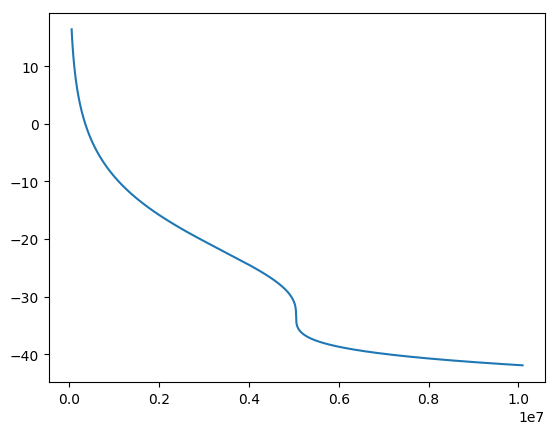

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3275c6910>

In [43]:
pcvals = linspace(0.01pc,2pc,1000)
ssvals = [Δs_Carnotline2(pc) for pc in pcvals]
plot(pcvals,ssvals)

In [44]:
p2 = fzero(Δs_Carnotline2,0.1pc)
0.5pc

2.523e6

In [45]:
0.5pc

2.523e6

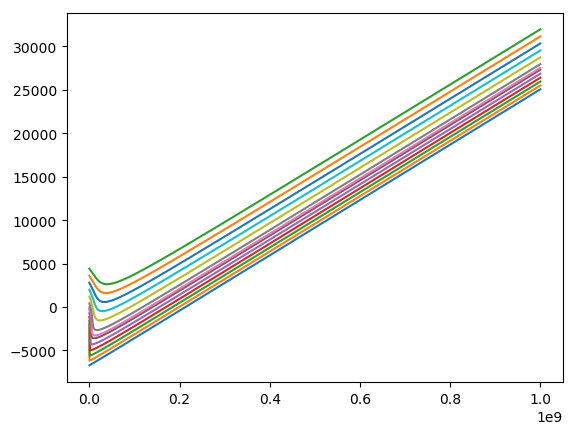

In [46]:
#-----Define parameters-----#

c1 = 25.460                           #J/mol.K
c2 = 1.519e-2                         #J/mol.K^2
c3 = -0.715e-5                        #J/mol.K^3
c4 = 1.311e-9                         #J/mol.K^4
Tref = Tc                             #Reference temperature, K
hIGRef = 0                            #Reference Ideal Gas Enthalpy, J/mol

#-----Define Functions-----#

Z_actual(T,p) = Z(p,v_actual(T,p),T)                                           #Function for compressibility factor, Z, in terms of just T and p. This will undergo a step change at the phase transition.              
htakehIG(T,p) = R*T*(Z_actual(T,p)-1-a*p/(R^2*T^2)/Z_actual(T,p))              #Function of departure function in terms of T and p. This will also undergo a step change at the phase transition.
cpIG(T) = c1+c2*T+c3*T^2+c4*T^3                                                #Ideal gas heat capacity, J/K.mol
cpIGIntegral(T) = c1*(T-Tref) + c2/2*(T^2-Tref^2) + c3/3*(T^3-Tref^3) + c4/4*(T^4-Tref^4)              #Integral of ideal gas heat capacity between Tref and T, J/mol.
h(T,p) = htakehIG(T,p)+cpIGIntegral(T)


#-----Make Plots-----#

for Tloop in Tvals
    pvals = linspace(1e5,1e9,5000)
    hvals = [h(Tloop,p) for p in pvals]
    plot(pvals,hvals)
end

In [47]:
p_sat(Tc-1e-1)

5.035589539117697e6

In [48]:
Tc-2e-2

154.57999999999998

In [49]:
Tc

154.6

# Rough Work


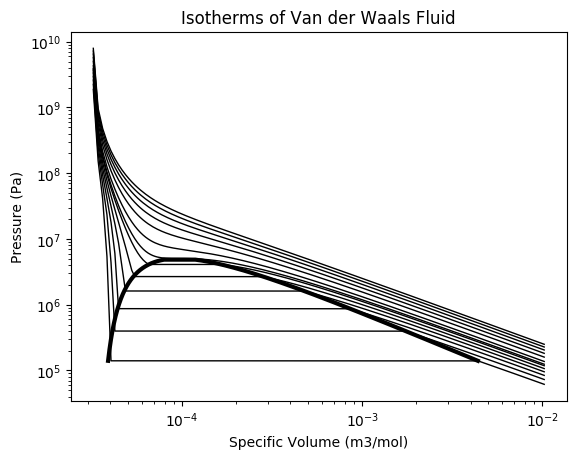

In [50]:
#-----Call packages-----#

using PyPlot                                                     #Call Plotting Package


#-----Define Parameters-----#

R = 8.314                                                        #Ideal gas constant, J/K.mol
a = 0.1381                                                       #a, VdW constant, m^6/mol^2
b = 3.184e-5                                                     #b, VdW constant, m3/mol
Tc = 154.6                                                       #Critical Temperature, K
pc = 5.046e6                                                     #Critical Pressure, Pa
Tvals = [linspace(0.5Tc,0.95Tc,6);Tc;linspace(1.1Tc,2Tc,6)]      #Values of Temperature for plotting, K


#-----Define Functions------#

p(v,T) = R*T/(v-b) - a/v^2                                       #Equation of State of VdW fluid, Pa
T(p,v) = (p+a/v^2)*(v-b)/R                                       #Rearranged Equation of State of VdW fluid, K
Z(p,v,T) = p*v/(R*T)                                             #Compressiblity Factor
f(p,Z,T) = p*exp((Z-1) - log(Z-b*p/(R*T)) - a*p/(R^2*T^2)/Z)     #Fugacity of VdW Fluid, Pa; Be aware that errors will occur if this is evaluated where p(v,T) < 0, as this will give Z-B < 0 as well.


#-----Define Function for Solving Cubic Equation using formula from Wikipedia, and Apply to VdW Equation-----#

function rootscubic(a1,a2,a3,a4)                                                           
    Δ = 18*a1*a2*a3*a4 - 4*a2^3*a4 + a2^2*a3^2 - 4a1*a3^3 - 27a1^2*a4^2    #Discriminant of cubic.
    Δ0 = a2^2 - 3*a1*a3                                                    #Constant Δ0 from Wikipedia page
    Δ1 = 2*a2^3 - 9*a1*a2*a3 + 27*a1^2*a4                                  #Constant Δ1 from Wikipedia page
    if Δ < 0                                                               #In this case, there is only 1 real root
        numroots = 1                                                       #numroots is the number of roots.
        C = cbrt((Δ1 + sign(Δ1)*sqrt(-27*a1^2*Δ))/2)                       #Constant C from the Wikipedia page
        root = -1/(3*a1)*(a2+C+Δ0/C)                                       #The one root of this equation
        return [numroots,root]                                             #Return the number of roots and the root as a vector
    elseif Δ > 0                                                           #In this case there are 3 real roots
        numroots = 3                                                       #numroots is the number of roots.
        C = ((Δ1 + sign(Δ1)*sqrt(-27*a1^2*Δ + 0im))/2)^(1/3)               #Constant C from the Wikipedia page
        ξ = -1/2+sqrt(3)/2*im                                              #Constant ξ from the Wikipedia page
        root1 = real(-1/(3*a1)*(a2+C+Δ0/C))                                #And these are the three roots
        root2 = real(-1/(3*a1)*(a2+ξ*C+Δ0/(ξ*C)))
        root3 = real(-1/(3*a1)*(a2+ξ^2*C+Δ0/(ξ^2*C)))
        return [numroots,root1,root2,root3]                                #Return the number of roots and the 3 roots as a vector
    elseif Δ == 0                                                          #Handle the special case of multiple roots
        if Δ0 == 0                                                         #From Wikipedia, the formula with 1 triple root
            numroots = 1
            root = -x2/(3x1)
            return [numroots,root]
        else
            numroots = 2                                                   #From Wikipedia, the formula with a double root (root1) and another single root
            root1 = (9*x1*x4-x2*x3)/(2Δ0)
            root2 = (4*x1*x2*x3-9*x1^2*x4-x2^3)/(x1*Δ0)
            return [numroots,root1,root2]
        end
    end
end
v(T,p) = rootscubic(p,-b*p-R*T,a,-a*b)                                     #Using the root finding algorithm, we constuct a VdW equation rearranged for specific volume, that returns either one solution (T>Tc) or 3 solutions, only 2 of which are physical (T<Tc), m3/mol


#-----Create function which calculates the saturation pressure as a function of temperature-----#

function p_sat(Ttemp)
    if rootscubic(R*Ttemp/(2a*b^2),-1/b^2,2/b,-1)[1] == 1                                                                    #If the temperature is above the critical point, the Van der Waals equation can be applied directly.
        return println("Temperature is above the critical temperature: there is no pressure at which liquid and vapour can coexist.")
    else
        vguess = mean(sort(rootscubic(R*Ttemp/(2a*b^2),-1/b^2,2/b,-1))[2:3])         #As described above, our first guess for the pressure will be at the point between the two stationary points of the VdW equation. Typically 3 stationary points are found when T < Tc, but one is at v < b, and so is non-physical and is ignored. m3/mol
        pguess = p(vguess,Ttemp)                                                     #Evaluate p at the first guess position, Pa
        fl = 0.0; fv = 1.0;                                                          #Initial dummy values for fugacity of liquid and gas, Pa
        while abs(fl-fv) > 1e-6                                                      #While liquid and gas phase fugacities difer by more than some small tolerance, keep iterating 
            fl = f(pguess,Z(pguess,v(Ttemp,pguess)[2],Ttemp),Ttemp)                  #Calculate liquid fugacity, Pa
            fv = f(pguess,Z(pguess,v(Ttemp,pguess)[4],Ttemp),Ttemp)                  #Calculate gas fugacity, Pa
            pguess = pguess*fl/fv                                                    #Update guess for saturation pressure - see part D of notes for why we use this updating procedure, Pa 
        end        
        return pguess                                                                #After convergence is achieved, return saturation pressure, Pa
    end
end


#-----Create function which calculates the *actual* vapor pressure-----#
#-----as a function of T and v (i.e. a function p_actual(v,T) that-----#
#-----accounts for the saturation region, using fugacity method)-------#


function p_actual(vtemp,Ttemp)
    if Ttemp>=Tc
        return p(vtemp,Ttemp)                                                        #If T > Tc, there is no need to account for the saturation region, and the VdW equation gives the actual pressure, pa
    else
        psatval = p_sat(Ttemp)                                                       #For T < Tc, the system may be in the saturation region. Use p_sat(T) to calculate the saturation pressure, Pa
        vliqsat = v(Ttemp,psatval)[2]                                                #Specific volume of saturated liquid at temperature T, m3/mol
        vgassat = v(Ttemp,psatval)[4]                                                #Specific volume of saturated gas at temperature T, m3/mol
        if vliqsat < vtemp < vgassat
            return psatval                                                           #If inside the saturation region, return saturation pressure, Pa
        else
            return  p(vtemp,Ttemp)                                                   #Otherwise, return pressure as predicted by VdW equation, Pa
        end
    end
end


#-----Make p-v plot-----#

#Plot Isotherms
vc = v(Tc,pc)[2]                                         #Critical volume, m3/mol
for i in 1:length(Tvals)
    Tloop = Tvals[i]
    vvals = linspace(1.01b,100vc,5000)                   #Values of which volume is plotted, m3/mol
    pvals = [p_actual(v,Tloop) for v in vvals]           #Calculate pressure values using p_actual(v,T), Pa
    loglog(vvals,pvals,"k",linewidth=1)                  #Plots Isotherms on loglog plot.
end

#Plot saturation curve.                                    
pvregionTvals = linspace(Tvals[1],Tc*0.99,500)           #We will also plot the boundary of the saturation region
pvregionpvals = zeros(1000)
pvregionvvals = zeros(1000)
counter = 1
for Ttemp in pvregionTvals                               
    pvregionpvals[counter] = p_sat(Ttemp)                                  #Saturation pressure at each temperature value, Pa
    pvregionpvals[1001 - counter] = p_sat(Ttemp)
    pvregionvvals[counter] = v(Ttemp,pvregionpvals[counter])[2]            #Saturated liquid specific volume at each temperature, Pa
    pvregionvvals[1001 - counter] = v(Ttemp,pvregionpvals[counter])[4]     #Saturated gas specific volume at each temperature, Pa
    counter += 1
end
loglog(pvregionvvals,pvregionpvals,"-k",linewidth=3)

#Some minor titivation
title("Isotherms of Van der Waals Fluid")
xlabel("Specific Volume (m3/mol)")
ylabel("Pressure (Pa)")


In [51]:
logspace(pvregionpvals)

LoadError: MethodError: no method matching logspace(::Array{Float64,1})[0m
Closest candidates are:
  logspace([1m[31m::Real[0m, [1m[31m::Real[0m) at range.jl:333
  logspace([1m[31m::Real[0m, [1m[31m::Real[0m, [1m[31m::Integer[0m) at range.jl:333[0m

In [52]:
-R*(Tc-1)/((vtemp-b)^2) + 2a/(vtemp^3)

LoadError: UndefVarError: vtemp not defined

In [53]:
-(vtemp-b)^2/(R*(Tc+100)) + vtemp^3/2a

LoadError: UndefVarError: vtemp not defined

In [54]:
(R*(Tc+100))*vtemp^3 - (vtemp-b)^2*2a 

LoadError: UndefVarError: vtemp not defined

In [55]:
(R*(Tc+100))*vtemp^3 - 2a*vtemp^2+4a*b*vtemp-2a*b^2

LoadError: UndefVarError: vtemp not defined

In [56]:
R*(Tc+100)/((vtemp-b)^2)

LoadError: UndefVarError: vtemp not defined

In [57]:
2a/(vtemp^3)

LoadError: UndefVarError: vtemp not defined

In [58]:
-(vtemp-b)^2/(R*(Tc+100)) 

LoadError: UndefVarError: vtemp not defined

In [59]:
vtemp^3/2a

LoadError: UndefVarError: vtemp not defined

In [60]:
2*a*b^2

2.8000758272e-10

In [61]:
vc

0.00010249491403520454

In [62]:
dpdv(v,T) = -R*T/(v-b)^2 + 2a/v^3   
cubictest(v,T) = R*T/(2a*b^2)*v^3 - v^2/b^2 + 2v/b - 1

cubictest (generic function with 1 method)

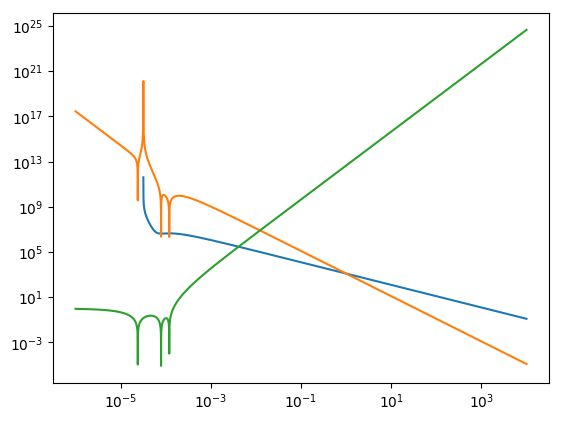

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x10f2f5850>

In [63]:
vvals = logspace(-6,4,100000)
pvals = [p(v,Tc-5) for v in vvals]
dpdvvals = [dpdv(v,Tc-5) for v in vvals]
cubictestvals = [cubictest(v,Tc-5) for v in vvals]
loglog(vvals,pvals)
loglog(vvals,abs(dpdvvals))
loglog(vvals,abs(cubictestvals))

In [64]:
dpdv(vc,Tc)

-9.574811873671875e8

In [65]:
minimum(abs(dpdvvals))

1.2437743803003553e-5

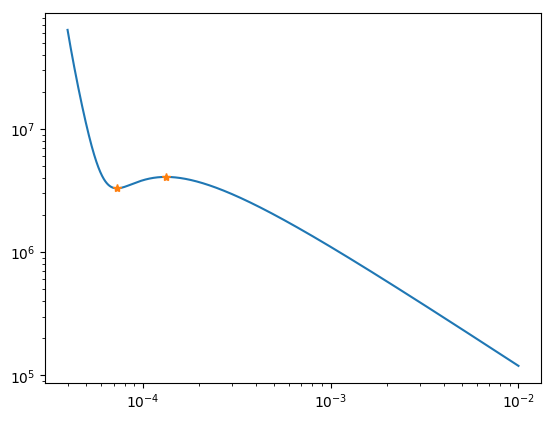

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32cf28750>

In [66]:
vvals = logspace(-4.4,-2,100000)
pvals = [p(v,Tc-10) for v in vvals]
vtempvals = rootscubic((R*(Tc-10))/(2a*b^2),-1/b^2,2/b,-1)
vsmall = sort(vtempvals[2:4])[2]
vlarge = sort(vtempvals[2:4])[3]
loglog(vvals,pvals)
loglog([vsmall,vlarge],[p(vsmall,Tc-10),p(vlarge,Tc-10)],"*")

In [67]:
vtempvals

4-element Array{Float64,1}:
 3.0        
 2.40559e-5 
 7.29303e-5 
 0.000132758

In [68]:
sort(vtempvals[2:4])

3-element Array{Float64,1}:
 2.40559e-5 
 7.29303e-5 
 0.000132758

In [69]:
mean([3,4,8])

5.0

# Old Code

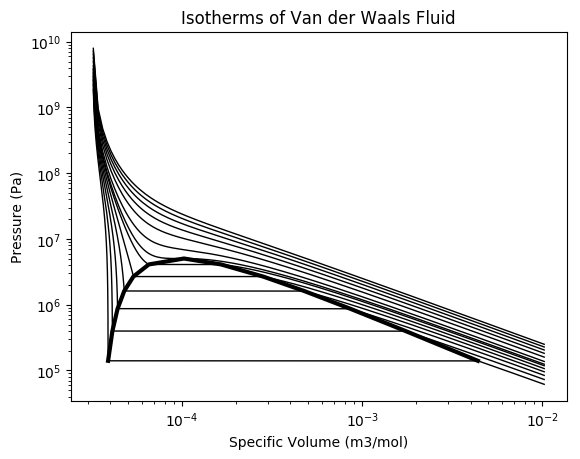

PyObject <matplotlib.text.Text object at 0x326f8d210>

In [70]:
#-----Call packages-----#

using PyPlot                                                     #Call Plotting Package


#-----Define Parameters-----#

R = 8.314                                                        #Ideal gas constant, J/K.mol
a = 0.1381                                                       #a, VdW constant, m^6/mol^2
b = 3.184e-5                                                     #b, VdW constant, m3/mol
Tc = 154.6                                                       #Critical Temperature, K
pc = 5.046e6                                                     #Critical Pressure, Pa
Tvals = [linspace(0.5Tc,0.95Tc,6);Tc;linspace(1.1Tc,2Tc,6)]      #Values of Temperature for plotting, K


#-----Define Functions------#

p(v,T) = R*T/(v-b) - a/v^2                                                                #Equation of State of VdW fluid, Pa
T(p,v) = (p+a/v^2)*(v-b)/R                                                                #Rearranged Equation of State of VdW fluid, K
Z(p,v,T) = p*v/(R*T)                                                                      #Compressiblity Factor
f(p,Z,T) = p*exp((Z-1) - log(Z-b*p/(R*T)) - a*p/(R^2*T^2)/Z)     #Fugacity of VdW Fluid, Pa; There is no need to worry about Z-B < 0, as in all that follows below we will be careful to only evaluate 


#-----Define Function for Solving Cubic Equation using formula from Wikipedia, and Apply to VdW Equation-----#

function rootscubic(a1,a2,a3,a4)                                                           
    Δ = 18*a1*a2*a3*a4 - 4*a2^3*a4 + a2^2*a3^2 - 4a1*a3^3 - 27a1^2*a4^2    #Discriminant of cubic.
    Δ0 = a2^2 - 3*a1*a3                                                    #Constant Δ0 from Wikipedia page
    Δ1 = 2*a2^3 - 9*a1*a2*a3 + 27*a1^2*a4                                  #Constant Δ1 from Wikipedia page
    if Δ < 0                                                               #In this case, there is only 1 real root
        numroots = 1                                                       #numroots is the number of roots.
        C = cbrt((Δ1 + sign(Δ1)*sqrt(-27*a1^2*Δ))/2)                       #Constant C from the Wikipedia page
        root = -1/(3*a1)*(a2+C+Δ0/C)                                       #The one root of this equation
        return [numroots,root]                                             #Return the number of roots and the root as a vector
    elseif Δ > 0                                                           #In this case there are 3 real roots
        numroots = 3                                                       #numroots is the number of roots.
        C = ((Δ1 + sign(Δ1)*sqrt(-27*a1^2*Δ + 0im))/2)^(1/3)               #Constant C from the Wikipedia page
        ξ = -1/2+sqrt(3)/2*im                                              #Constant ξ from the Wikipedia page
        root1 = real(-1/(3*a1)*(a2+C+Δ0/C))                                #And these are the three roots
        root2 = real(-1/(3*a1)*(a2+ξ*C+Δ0/(ξ*C)))
        root3 = real(-1/(3*a1)*(a2+ξ^2*C+Δ0/(ξ^2*C)))
        return [numroots,root1,root2,root3]                                #Return the number of roots and the 3 roots as a vector
    end
    return println("Δ=0, bad luck you found the degenerate case, are you at Tc?")    #Return error if you picked the degenerate case (e.g. the critical temperature.)
end
v(T,p) = rootscubic(p,-b*p-R*T,a,-a*b)                                               #Using the root finding algorithm, we constuct a VdW equation rearranged for specific volume, m3/mol


#-----Calculate Vapour Pressures for T<Tc using fugacity method-----#

pvap_vals = []                                                               #In this vector we will store the vapor-pressure values for T<Tc (i.e. the pressure values of the horizontal lines in the saturation region)
for Tloop in Tvals
    if Tloop < Tc                                                            #We only need to find the vapor-liquid equilibrium when we are below the critical temperature
        ptestvals = linspace(pc/50,pc,10000)                                 #To be safe, we will look at 10000 vales of pressure between pc/50 and pc
        numroottracker = zeros(10000)                                        #This function stores the number of roots at each pressure value - we are looking for the pressure values with 3 roots.
        counter = 0
        for ploop in ptestvals
            counter += 1
            numroottracker[counter] = v(Tloop,ploop)[1]                      #Save the number of roots in numroottracker
        end
        pguess = ptestvals[Int(ceil((findfirst(numroottracker,3)+findlast(numroottracker,3))/2))]          #Choose, for our first guess, a p value in the middle of the range of values with 3 roots.
        fl = 0.0; fv = 1.0;
        while abs(fl-fv) > 1e-6                                              #While liquid and gas phase fugacities difer by more than some small tolerance, keep iterating 
            fl = f(pguess,Z(pguess,v(Tloop,pguess)[2],Tloop),Tloop)          #Calculate liquid fugacity, Pa
            fv = f(pguess,Z(pguess,v(Tloop,pguess)[4],Tloop),Tloop)          #Calculate gas fugacity, Pa
            pguess = pguess*fl/fv                                            #Update guess for saturation pressure, Pa
        end
        push!(pvap_vals,pguess)                                              #Store final saturation pressure value, Pa
    end
end


#-----Make p-V plot-----#

#Plot Isotherms
vc = v(Tc,pc)[2]                             #Critical volume, m3/mol
for i in 1:13
    Tloop = Tvals[i]
    if Tloop < Tc                                                            #Plots below the critical temperature are more difficult: we divide them into 3 sections: volumes beneath the saturation region, the saturation region, and volumes above the saturation region.
        ploop = pvap_vals[i]
        vlow  = v(Tloop,ploop)[2]                                            #Volume of saturated liquid, m3/mol
        vhigh = v(Tloop,ploop)[4]                                            #Volume of saturated gas, m3/mol
        vvalslow = linspace(1.01b,vlow,5000)
        vvalssat = linspace(vlow,vhigh,5000)
        vvalshigh= linspace(vhigh,100vc,5000)
        vvals = [vvalslow;vvalssat;vvalshigh]
        pvals = [[p(v,Tloop) for v in vvalslow];[ploop for v in vvalssat];[p(v,Tloop) for v in vvalshigh]]    #Evaluate pressures in various regimes, Pa
        loglog(vvals,pvals,"k",linewidth=1)                                                                   #Plot isotherms on loglog scale
    else                                                     #Things are simpler for T >= Tc
        vvals = linspace(1.01b,100vc,5000)                   #Values of which volume is plotted, m3/mol
        pvals = [p(v,Tloop) for v in vvals]                  #Calculate pressure values using VdW equation, Pa
        loglog(vvals,pvals,"k",linewidth=1)                  #Plots Isotherms on loglog plot.
    end
end

#Plot Vapor-liquid Line
counter = 1                                                 #Here we plot the vapor-liquid line - this is just a matter of constructing the right vectors to connect the dots around the vapor-liquid region.
vvap_plot = zeros(length(pvap_vals)*2+1)
pvap_plot = zeros(length(pvap_vals)*2+1)
for ploop in pvap_vals
    vvap_plot[counter] = v(Tvals[counter],pvap_vals[counter])[2]
    vvap_plot[end-counter+1] = v(Tvals[counter],pvap_vals[counter])[4]
    pvap_plot[counter] = ploop
    pvap_plot[end-counter+1] = ploop
    counter += 1
end
pvap_plot[length(pvap_vals)+1] = pc
vvap_plot[length(pvap_vals)+1] = vc
loglog(vvap_plot,pvap_plot, "-k",linewidth=3)

#Some minor titivation
title("Isotherms of Van der Waals Fluid")
xlabel("Specific Volume (m3/mol)")
ylabel("Pressure (Pa)")


In [71]:
function p_sat(T)
    if T>=Tc
        return println("You're Temperature is above the critical temperature, there is no pressure at which liquid and vapour can coexist.")
    else                                                          #Plots below the critical temperature are more difficult: we divide them into 3 sections: volumes beneath the saturation region, the saturation region, and volumes above the saturation region.
        ptestvals = linspace(pc/50,pc,10000)                                 #To be safe, we will look at 10000 vales of pressure between pc/50 and pc
        numroottracker = zeros(10000)                                        #This function stores the number of roots at each pressure value - we are looking for the pressure values with 3 roots.
        counter = 0
        for ploop in ptestvals
            counter += 1
            numroottracker[counter] = v(T,ploop)[1]                      #Save the number of roots in numroottracker
        end
        pguess = ptestvals[Int(ceil((findfirst(numroottracker,3)+findlast(numroottracker,3))/2))]          #Choose, for our first guess, a p value in the middle of the range of values with 3 roots.
        fl = 0.0; fv = 1.0;
        while abs(fl-fv) > 1e-6                                              #While liquid and gas phase fugacities difer by more than some small tolerance, keep iterating 
            fl = f(pguess,Z(pguess,v(T,pguess)[2],T),T)          #Calculate liquid fugacity, Pa
            fv = f(pguess,Z(pguess,v(T,pguess)[4],T),T)          #Calculate gas fugacity, Pa
            pguess = pguess*fl/fv                                            #Update guess for saturation pressure, Pa
        end
        return pguess
    end
end

function p_actual(vval,Tval)
    if Tval>=Tc
        return p(vval,Tval)
    else
        psatval = p_sat(Tval)
        vliqsat = v(Tval,psatval)[2]
        vgassat = v(Tval,psatval)[4]
        if vliqsat < v < vgassat
            return psatval
        else
            return  p(vval,Tval)
        end
    end
end

function v_actual(Tval,pval)
    numroots = v(Tval,pval)[1]
    psatval = p_sat(Tval)
    if pval >= psatval 
        return v(Tval,pval)[2]
    elseif pval < psatval && numroots == 1
        return v(Tval,pval)[2]
    elseif pval < psatval && numroots == 3
        return v(Tval,pval)[4]
    end
end

v_actual (generic function with 1 method)